# RecomMovies
Building a recommendation model in a Neo4j graph database using movies data webscraped from IMDB

Author: Mei Yong <br>
github.com/mei-yong/RecomMovies

# Initial Setup

In [ ]:
# In your terminal, install the following packages
'''
pip install py2neo
pip install python-igraph
pip install textblob
'''

In [1]:
# Import libraries
import pandas as pd
from py2neo import Graph
from IPython.display import Image
#from igraph import Graph as IGraph

In [2]:
# Initialise the graph db
uri = "bolt://localhost:7687"
user = "neo4j"
password = "password"
graph = Graph(uri=uri, user=user, password=password)

In [3]:
# Test Neo4j connection
query = "MATCH (n) RETURN COUNT(n) AS numberOfNodes"
graph.run(query).evaluate()

1328

In [4]:
# Test connection between Neo4j and CSV file location
query = '''
LOAD CSV WITH HEADERS FROM
"file:///movies.csv"
AS row WITH row LIMIT 1 RETURN row
'''
graph.run(query).evaluate()

{'netflix_id': '1905.0',
 'imdb_id': 'tt0325980',
 'year': '2003',
 'title': 'Pirates of the Caribbean: The Curse of the Black Pearl'}

Useful Links

Cypher Shell
https://neo4j.com/docs/operations-manual/current/tools/cypher-shell/

Combining 2 Neo4j collections into 1 and getting distinct values from it
https://stackoverflow.com/questions/34659152/cyhper-combine-two-columns-into-a-single

Load CSV tips
https://neo4j.com/developer/guide-import-csv/
https://gist.github.com/jexp/d788e117129c3730a042


https://neo4j.com/blog/common-confusions-cypher/
https://neo4j.com/developer/guide-sql-to-cypher/


DROP CONSTRAINT ON (book:Book) ASSERT book.isbn IS UNIQUE


# Inspect Datasets

In [5]:
movies = pd.read_csv("data/movies_imdb.csv")
movies.sample(3)

,netflix_id,imdb_id,year,title,summary_text,director,actor_1,actor_2,actor_3,genre_1,genre_2,genre_3,summary_text_new,descriptor_1,descriptor_2,descriptor_3
196,442.0,tt0095647,1988,Mississippi Burning,"Two F.B.I. Agents, with wildly different style...",Alan Parker,Gene Hackman,Willem Dafoe,Frances McDormand,Crime,Drama,History,two f b i agents with wildly different styles ...,wildly,styles,rights
56,197.0,tt0364045,2004,Taking Lives,An FBI profiler is called in by French Canadia...,D.J. Caruso,Angelina Jolie,Ethan Hawke,Kiefer Sutherland,Crime,Mystery,Thriller,an fbi profiler is called in by french canadia...,profiler,canadian,victim
276,3680.0,tt0113243,1995,Hackers,Hackers are blamed for making a virus that wil...,Iain Softley,Jonny Lee Miller,Angelina Jolie,Jesse Bradford,Comedy,Crime,Drama,hackers are blamed for making a virus that wil...,virus,tankers,oil


In [6]:
ratings = pd.read_csv("data/ratings.csv")
ratings.sample(3)

,user_id,rating,rating_date,movie_id
24579,1033930,3.0,2004-10-16,3265.0
31959,1061195,4.0,2003-10-03,4109.0
21843,1984315,3.0,2005-05-14,2913.0


In [7]:
users = pd.read_csv("data/users.csv")
users.sample(3)

,user_id,name
148,2225743,Andy Morones
26,2457095,Twanda Witcher
36,1710658,Ouida Steinman


In [8]:
genres = pd.read_csv("data/movie_genres.csv")
genres.sample(3)

,id,name
17,18,Family
18,19,Biography
8,9,Romance


In [9]:
artists = pd.read_csv("data/movie_persons.csv")
artists.sample(3)

,id,name
52,53,Walter Lang
342,343,Richard Donner
631,632,D.J. Caruso


# Helper functions to QA the Neo4j graph db creation

In [10]:
def check_dupes(label, uid):
    # Get number of all nodes of a particular label
    q_all_nodes = "MATCH (n:" + label + ") RETURN COUNT(n)"
    all_nodes = graph.run(q_all_nodes).evaluate()
    
    q_distinct_nodes = "MATCH (n:" + label + ") RETURN COUNT(DISTINCT n." + uid + ")"
    distinct_nodes = graph.run(q_distinct_nodes).evaluate()
    
    result = {'all_nodes': all_nodes, 'distinct_nodes': distinct_nodes}
    print(result)

# Build the base graph db

In [11]:
# Create uniqueness constraints & indexes
graph.run("CREATE CONSTRAINT ON (m:Movie) ASSERT m.id IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (u:User) ASSERT u.id IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (a:Artist) ASSERT a.name IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (g:Genre) ASSERT g.name IS UNIQUE")

In [13]:
# Create movie nodes
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MERGE (m:Movie { id: toInteger(row.netflix_id) })
ON CREATE SET
    m.imdb = row.imdb_id,
    m.title = row.title,
    m.year = toInteger(row.year)
'''
graph.run(query)

In [14]:
# QA movie nodes
check_dupes(label='Movie', uid='id')

{'all_nodes': 300, 'distinct_nodes': 300}


In [15]:
# Create user nodes
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///users.csv" AS row
MERGE (u:User {id:toInteger(row.user_id)})
ON CREATE SET u.name = trim(row.name)
'''
graph.run(query)

In [16]:
# QA user nodes
check_dupes(label='User', uid='id')

{'all_nodes': 155, 'distinct_nodes': 155}


In [17]:
# Create rating relationships
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///ratings.csv" AS row
WITH row, SPLIT(row.rating_date, "-") AS date
MATCH (u:User {id: toInteger(row.user_id)})
MATCH (m:Movie {id: toInteger(row.movie_id)})
MERGE (u)-[r:RATED]->(m)
ON CREATE SET
    r.rating = toInteger(row.rating),
    r.year = toInteger(date[0]),
    r.month = toInteger(date[1]),
    r.day = toInteger(date[2])
'''
graph.run(query)

In [18]:
# QA rating relationships
graph.run("MATCH ()-[r:RATED]-() RETURN COUNT(DISTINCT r)").evaluate()

35594

In [19]:
# Add average rating & total ratings to movie nodes
query = '''
MATCH (m:Movie)<-[r:RATED]-()
WITH m, 
    AVG(r.rating) as average_rating, 
    COUNT(r.rating) as total_ratings
SET m.avg_rating = round(100* average_rating) / 100,
    m.total_ratings = total_ratings
'''
graph.run(query)

In [20]:
# Get top 10 highly rated movies
query = '''
MATCH (m:Movie)
RETURN m.title as movie, m.avg_rating as rating
ORDER BY m.avg_rating DESC LIMIT 10
'''
result = graph.run(query)

for row in result:
    print(row)

<Record movie='The Silence of the Lambs' rating=4.29>
<Record movie='The Sixth Sense' rating=4.26>
<Record movie='Braveheart' rating=4.18>
<Record movie='Jaws' rating=4.17>
<Record movie='Batman Begins' rating=4.08>
<Record movie='Ray' rating=4.03>
<Record movie='Pirates of the Caribbean: The Curse of the Black Pearl' rating=4.03>
<Record movie='Shrek 2' rating=4.01>
<Record movie='Lethal Weapon' rating=3.9>
<Record movie='The Bourne Supremacy' rating=3.89>


In [21]:
# Get top 10 least rated movies
query = '''
MATCH (m:Movie)
RETURN m.title as movie, m.total_ratings as num_ratings
ORDER BY m.total_ratings ASC LIMIT 10
'''
result = graph.run(query)

for row in result:
    print(row)

<Record movie='Control Room' num_ratings=49>
<Record movie='The Door in the Floor' num_ratings=54>
<Record movie='Amores Perros' num_ratings=65>
<Record movie='A Love Song for Bobby Long' num_ratings=66>
<Record movie='Beauty Shop' num_ratings=66>
<Record movie='Friday Night Lights' num_ratings=68>
<Record movie='Confessions of a Teenage Drama Queen' num_ratings=74>
<Record movie='Beyond Borders' num_ratings=78>
<Record movie='A Cinderella Story' num_ratings=78>
<Record movie='Home Alone 2: Lost in New York' num_ratings=80>


In [22]:
# Try to find hidden gems - movies with few but highly scored ratings
query = '''
MATCH (m:Movie) WHERE m.avg_rating >=4
RETURN m ORDER BY m.total_ratings ASC LIMIT 10
'''
result = graph.run(query)

for row in result:
    print(row)

<Record m=(_91:Movie {avg_rating: 4.08, id: 3864, imdb: 'tt0372784', title: 'Batman Begins', total_ratings: 110, year: 2005})>
<Record m=(_27:Movie {avg_rating: 4.03, id: 886, imdb: 'tt0350258', title: 'Ray', total_ratings: 118, year: 2004})>
<Record m=(_5:Movie {avg_rating: 4.01, id: 3938, imdb: 'tt0298148', title: 'Shrek 2', total_ratings: 137, year: 2004})>
<Record m=(_12:Movie {avg_rating: 4.18, id: 2782, imdb: 'tt0112573', title: 'Braveheart', total_ratings: 145, year: 1995})>
<Record m=(_55:Movie {avg_rating: 4.17, id: 798, imdb: 'tt0073195', title: 'Jaws', total_ratings: 148, year: 1975})>
<Record m=(_0:Movie {avg_rating: 4.03, id: 1905, imdb: 'tt0325980', title: 'Pirates of the Caribbean: The Curse of the Black Pearl', total_ratings: 149, year: 2003})>
<Record m=(_15:Movie {avg_rating: 4.29, id: 2862, imdb: 'tt0102926', title: 'The Silence of the Lambs', total_ratings: 150, year: 1991})>
<Record m=(_6:Movie {avg_rating: 4.26, id: 4306, imdb: 'tt0167404', title: 'The Sixth Sense

In [23]:
# Create artist nodes
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movie_persons.csv" AS row
WITH row WHERE row.name IS NOT NULL
MERGE (:Artist {name: trim(row.name)})
'''
graph.run(query)

In [24]:
# QA check an artist node was created
result = graph.run("MATCH (a:Artist) WHERE a.name='Johnny Depp' RETURN a")
for row in result:
    print(row)

<Record a=(_864:Artist {name: 'Johnny Depp'})>


In [25]:
# QA artist nodes
check_dupes(label='Artist', uid='name')

{'all_nodes': 849, 'distinct_nodes': 849}


In [26]:
# Create genre nodes
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movie_genres.csv" AS row
WITH row WHERE row.name IS NOT NULL
MERGE (:Genre {name: toLower(trim(row.name))})
'''
graph.run(query)

In [27]:
# QA genre nodes
check_dupes(label='Genre', uid='name')

{'all_nodes': 24, 'distinct_nodes': 24}


In [28]:
# Create relationships between directors and movies
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MATCH (m:Movie {id: toInteger(row.netflix_id)})
MATCH (a:Artist {name: row.director})
MERGE (m)<-[:DIRECTED]-(a)
'''
graph.run(query)

In [29]:
# Create relationships between actors and movies
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MATCH (m:Movie {id: toInteger(row.netflix_id)})
MATCH (a:Artist {name: row.actor_1})
MERGE (m)<-[:ACTED_IN]-(a)
'''
graph.run(query)

query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MATCH (m:Movie {id: toInteger(row.netflix_id)})
MATCH (a:Artist {name: row.actor_2})
MERGE (m)<-[:ACTED_IN]-(a)
'''
graph.run(query)

query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MATCH (m:Movie {id: toInteger(row.netflix_id)})
MATCH (a:Artist {name: row.actor_3})
MERGE (m)<-[:ACTED_IN]-(a)
'''
graph.run(query)

In [30]:
# Create relationships between genres and movies
query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MATCH (m:Movie {id: toInteger(row.netflix_id)})
MATCH (g:Genre {name: toLower(row.genre_1)})
MERGE (m)-[:HAS_GENRE]->(g)
'''
graph.run(query)

query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MATCH (m:Movie {id: toInteger(row.netflix_id)})
MATCH (g:Genre {name: toLower(row.genre_2)})
MERGE (m)-[:HAS_GENRE]->(g)
'''
graph.run(query)

query = '''
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS
FROM "file:///movies_imdb.csv" AS row
MATCH (m:Movie {id: toInteger(row.netflix_id)})
MATCH (g:Genre {name: toLower(row.genre_3)})
MERGE (m)-[:HAS_GENRE]->(g)
'''
graph.run(query)

In [31]:
# QA check all nodes & relationships for Final Fantasy
results = graph.run("MATCH (m:Movie)-[r]-(n) WHERE m.title CONTAINS 'Final Fantasy' RETURN m, r, n")
for row in results:
    print(row)

<Record m=(_274:Movie {avg_rating: 2.85, id: 1983, imdb: 'tt0173840', title: 'Final Fantasy: The Spirits Within', total_ratings: 110, year: 2001}) r=(Amira Kim)-[:RATED {day: 10, month: 8, rating: 5, year: 2005}]->(_274) n=(_380:User {id: 447759, name: 'Amira\u00a0Kim'})>
<Record m=(_274:Movie {avg_rating: 2.85, id: 1983, imdb: 'tt0173840', title: 'Final Fantasy: The Spirits Within', total_ratings: 110, year: 2001}) r=(Andy Morones)-[:RATED {day: 24, month: 2, rating: 4, year: 2003}]->(_274) n=(_460:User {id: 2225743, name: 'Andy\u00a0Morones'})>
<Record m=(_274:Movie {avg_rating: 2.85, id: 1983, imdb: 'tt0173840', title: 'Final Fantasy: The Spirits Within', total_ratings: 110, year: 2001}) r=(Rochelle Hertel)-[:RATED {day: 13, month: 5, rating: 1, year: 2002}]->(_274) n=(_365:User {id: 1876520, name: 'Rochelle\u00a0Hertel'})>
<Record m=(_274:Movie {avg_rating: 2.85, id: 1983, imdb: 'tt0173840', title: 'Final Fantasy: The Spirits Within', total_ratings: 110, year: 2001}) r=(Hosea Brant

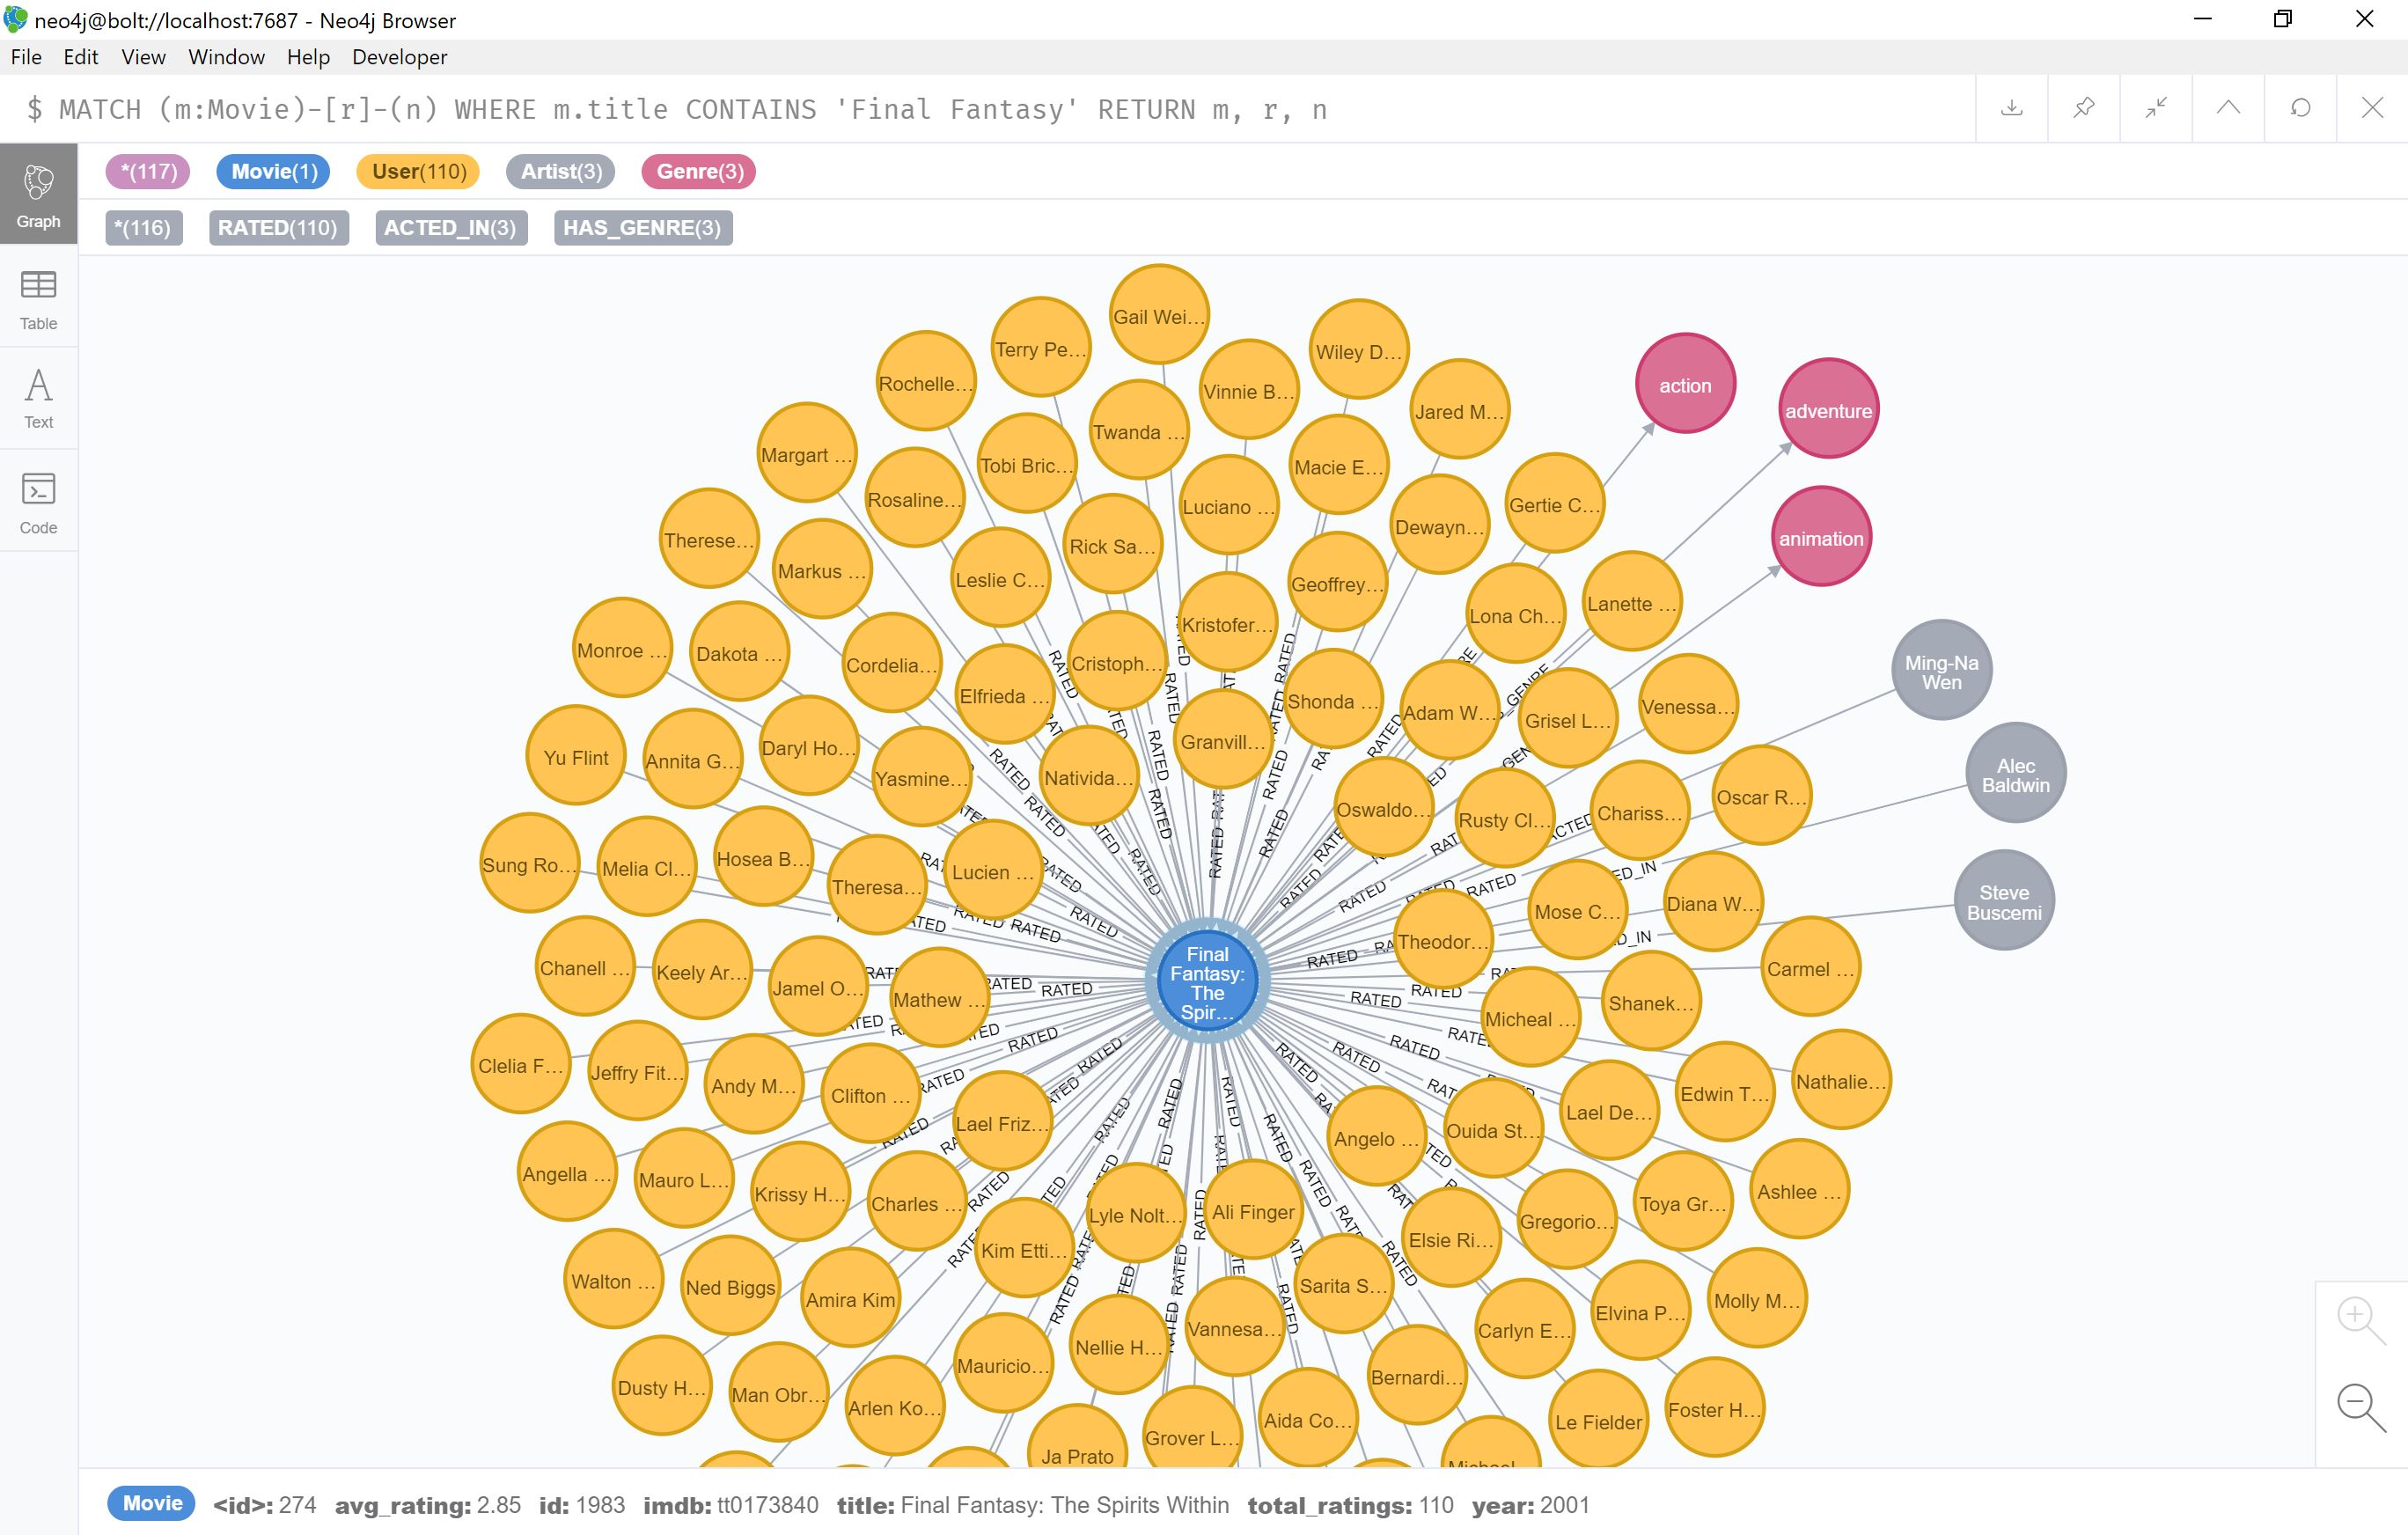

In [32]:
Image(filename="images/final_fantasy.jpg") 

In [33]:
# QA check all nodes & relationships for The Pacifier
results = graph.run("MATCH (m:Movie)-[r]-(n) WHERE m.title CONTAINS 'Pacifier' RETURN m, r, n")
for row in results:
    print(row)

<Record m=(_129:Movie {avg_rating: 3.54, id: 334, imdb: 'tt0395699', title: 'The Pacifier', total_ratings: 90, year: 2005}) r=(Summer Funk)-[:RATED {day: 6, month: 7, rating: 3, year: 2005}]->(_129) n=(_361:User {id: 789014, name: 'Summer\u00a0Funk'})>
<Record m=(_129:Movie {avg_rating: 3.54, id: 334, imdb: 'tt0395699', title: 'The Pacifier', total_ratings: 90, year: 2005}) r=(Gregorio Harmer)-[:RATED {day: 29, month: 10, rating: 4, year: 2005}]->(_129) n=(_457:User {id: 908205, name: 'Gregorio\u00a0Harmer'})>
<Record m=(_129:Movie {avg_rating: 3.54, id: 334, imdb: 'tt0395699', title: 'The Pacifier', total_ratings: 90, year: 2005}) r=(Isidra Johannsen)-[:RATED {day: 24, month: 9, rating: 5, year: 2005}]->(_129) n=(_308:User {id: 1932594, name: 'Isidra\u00a0Johannsen'})>
<Record m=(_129:Movie {avg_rating: 3.54, id: 334, imdb: 'tt0395699', title: 'The Pacifier', total_ratings: 90, year: 2005}) r=(Sung Rowles)-[:RATED {day: 17, month: 9, rating: 5, year: 2005}]->(_129) n=(_317:User {id: 1

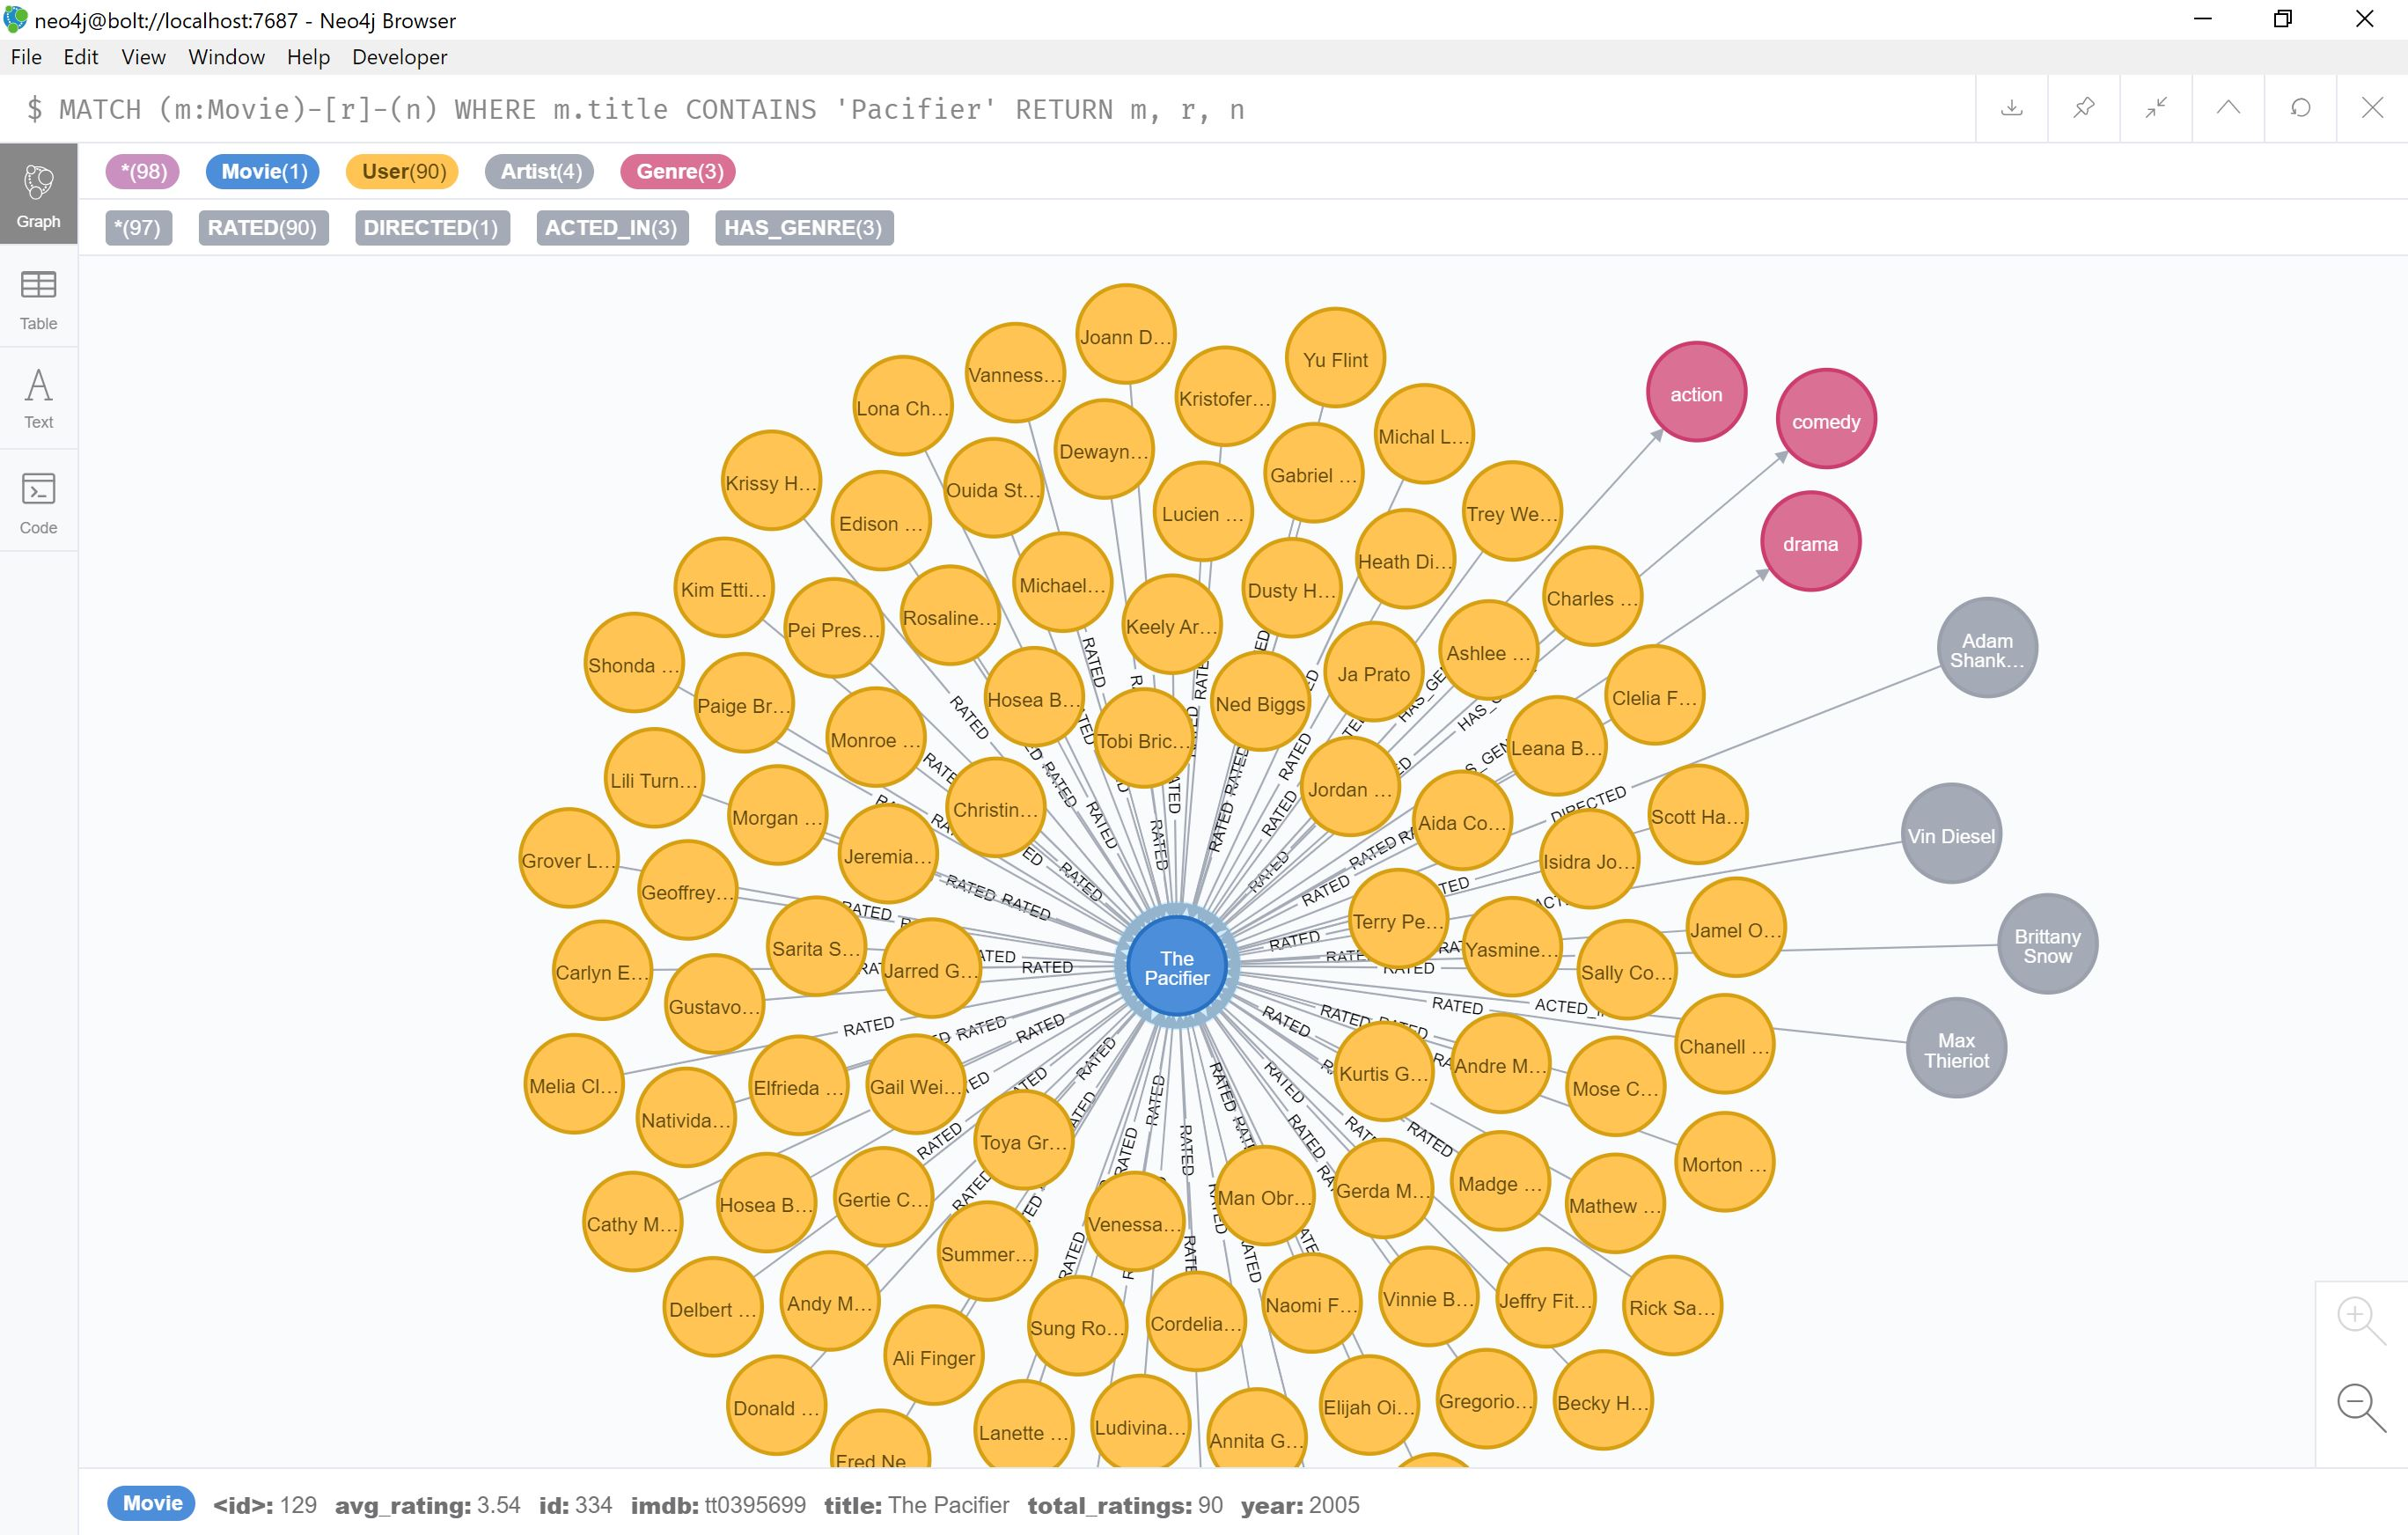

In [34]:
Image(filename="images/pacifier.jpg") 

# Clustering

Find all pairs of genres and find the number of common movies that share each pair of topics. Use this weight to build a graph of the form (Movie)-[:OCCURS_WITH {weight}]-(Movie)

TODO how to incorporate directors & actors into the weighting?


In [35]:
# Find genre pairs and use the frequency of said pairs as weight
query = '''
MATCH (g1:Genre)<-[:HAS_GENRE]-()-[:HAS_GENRE]->(g2:Genre)
WHERE ID(g1) < ID(g2)
RETURN g1.name, g2.name, COUNT(*) AS weight
ORDER BY weight DESC
LIMIT 10
'''
results = graph.run(query)

for row in results:
    print(row)

<Record g1.name='comedy' g2.name='drama' weight=51>
<Record g1.name='drama' g2.name='romance' weight=41>
<Record g1.name='comedy' g2.name='romance' weight=36>
<Record g1.name='drama' g2.name='crime' weight=31>
<Record g1.name='action' g2.name='adventure' weight=30>
<Record g1.name='action' g2.name='crime' weight=28>
<Record g1.name='comedy' g2.name='adventure' weight=24>
<Record g1.name='drama' g2.name='biography' weight=19>
<Record g1.name='comedy' g2.name='action' weight=19>
<Record g1.name='thriller' g2.name='drama' weight=19>


TODO
* look up community detection / clustering
* pick a method and find clusters
* add clusters to the graph db as (m:Movie)-[:IN_CLUSTER]->(c:Cluster {id: ##})

https://jeremykun.com/tag/walktrap/ <br>
https://www-complexnetworks.lip6.fr/~latapy/Publis/communities.pdf

iGraph - Python module for creating and modelling virtual graphs <br>
https://igraph.org/python/doc/tutorial/tutorial.html


# User Recommendations
We're going to go with Oswaldo as an example case - because I like his name

In [36]:
# Recommend other movies of similar genres
query = '''
MATCH (user:User)-[:RATED]->(m:Movie)-[:HAS_GENRE]->(g:Genre)<-[:HAS_GENRE]-(otherMovie:Movie)
WHERE user.name CONTAINS "Oswaldo" 
    AND NOT (user)-[:RATED]->(otherMovie)
RETURN otherMovie.title,
    COUNT(*) AS genresInCommon
ORDER BY genresInCommon DESC
LIMIT 5
'''
results = graph.run(query)

for row in results:
    print(row)

<Record otherMovie.title='The Pacifier' genresInCommon=267>
<Record otherMovie.title='In Good Company' genresInCommon=258>
<Record otherMovie.title='Uptown Girls' genresInCommon=258>
<Record otherMovie.title='Garden State' genresInCommon=258>
<Record otherMovie.title='Bend It Like Beckham' genresInCommon=258>


In [ ]:
# Recommend other movies in similar clusters
query = '''
MATCH (user:User)-[:RATED]->(m:Movie)-[:IN_CLUSTER]->(c:Cluster)<-[:IN_CLUSTER]-(otherMovie:Movie)
WHERE user.name CONTAINS "Oswaldo" 
    AND NOT (user)-[:RATED]->(otherMovie)
RETURN otherMovie.title,
    COUNT(*) AS clustersInCommon
ORDER BY clustersInCommon DESC
LIMIT 5
'''
results = graph.run(query)

for row in results:
    print(row)